In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import ast

In [3]:
# load in atbats
first_base = pd.read_csv('atbats_second_solo.csv')

first_base['runner_id'] = first_base['dict_players'].apply(lambda x: list(ast.literal_eval(x).keys())[-1])
# load in stolen bases
stolen_df = pd.read_csv('stolen_df_2.csv')

stolen_df.sort_values(by='Date')

data_exp = {
    "Runners": ['0', "1", "2", "1,2", "3", "1,3", "2,3", "1,2,3"],
    "0 Outs": [0.461, 0.831, 1.068, 1.373, 1.426, 1.798, 1.920, 2.282],
    "1 Outs": [0.243, 0.489, 0.644, 0.908, 0.865, 1.140, 1.352, 1.520],
    "2 Outs": [0.095, 0.214, 0.305, 0.343, 0.413, 0.471, 0.570, 0.736],
}


exp_run_base = pd.DataFrame(data_exp)

stolen_subset = stolen_df[['Result', 'Date', 'runner_id']]

# merge datasets on id and date

final_df = pd.merge(stolen_subset, first_base, on=['Date', 'runner_id'], how='inner')

final_df.sort_values(by='Date')

,Result,Date,runner_id,Unnamed: 0,Batter_name,Rbi_outcome,Rbi_stay,Success_steal,Success_stay,Outs,homeScore,awayScore,inning,isTopInning,Isout,Current_outs,dict_players
12954,1,2016-04-08,572821,4362,Joe Mauer,0,0,0.50,0.25,2,4,3,9,True,True,1,"{'init': 0, 572821: 2}"
12952,1,2016-04-08,572821,4362,Joe Mauer,0,0,0.50,0.25,2,4,3,9,True,True,1,"{'init': 0, 572821: 2}"
12953,1,2016-04-08,572821,4362,Joe Mauer,0,0,0.50,0.25,2,4,3,9,True,True,1,"{'init': 0, 572821: 2}"
12948,0,2016-04-10,456488,4459,Brian Dozier,1,0,0.40,0.05,3,0,0,5,True,True,1,"{'init': 0, 456488: 2}"
12947,0,2016-04-10,456488,4459,Brian Dozier,1,0,0.40,0.05,3,0,0,5,True,True,1,"{'init': 0, 456488: 2}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5649,0,2023-09-30,682928,61905,Lane Thomas,1,0,0.45,0.20,1,5,3,9,True,True,1,"{'init': 0, 682928: 2}"
5655,1,2023-09-30,682622,61895,TJ Friedl,1,0,0.35,0.15,2,11,5,5,True,True,1,"{'init': 0, 682622: 2}"
5656,1,2023-09-30,682622,61895,TJ Friedl,1,0,0.35,0.15,2,11,5,5,True,True,1,"{'init': 0, 682622: 2}"
5654,1,2023-09-30,660670,61884,Ozzie Albies,1,1,0.25,0.20,0,2,3,5,False,False,0,"{'init': 0, 660670: 2}"


In [4]:
final_df['Rbi_steal_unique'] = final_df.apply(lambda x: 1 if x['Rbi_outcome'] == 1 and x['Rbi_stay'] == 0 else 0, axis=1)

In [5]:
# list for successful steals

succes_steal = []

# iterate through df to obtain past successful steals

for row, i in final_df.iterrows():
    
    runner_id = i['runner_id']
    
    results = stolen_df.loc[(stolen_df['Date'] < i['Date']) & (stolen_df['runner_id'] == runner_id)].tail(10)['Result'].tolist()
    
    if len(results) < 10:
        succes_steal.append(np.nan)
        
    else:
        succes_steal.append(sum(results) / 10)

# documents percentage of successful steals        
final_df['Past_Steal_Success'] = succes_steal

final_df['Simulated_out'] = final_df['Current_outs'] + 1

In [6]:
# calculating utility if stolen, caught, and stays
# success_steal is the pecerntage of rbis the batter has hit at the next base and success_stay is rbis hit at current base

# diff in scores
final_df['Diff'] = final_df.apply(lambda x: x['awayScore'] - x['homeScore'] if x['isTopInning'] == 1 else x['homeScore'] - x['awayScore'], axis=1)

# re weight distribution so lower scores ex -1 and 1 have higher weight
final_df['Diff_transform'] = final_df['Diff'].apply(lambda x: np.exp(-(x**2) / (2 * (1.5)**2)))

final_df['Utility_steal'] = final_df.apply(lambda x: x['Past_Steal_Success'] * x['Success_steal'] * (exp_run_base.loc[(exp_run_base['Runners'] == "3")][f'{x["Current_outs"]} Outs'].tolist()[0]), axis=1)

final_df['Utility_caught'] = final_df.apply(lambda x: (1 - x['Past_Steal_Success']) * (0 - exp_run_base.loc[(exp_run_base['Runners'] == "2")][f'{x["Current_outs"]} Outs'].tolist()[0]) if x["Simulated_out"] == 3 else (1 - x['Past_Steal_Success']) * (exp_run_base.loc[(exp_run_base['Runners'] == "0")][f'{x["Simulated_out"]} Outs'].tolist()[0] - exp_run_base.loc[(exp_run_base['Runners'] == "2")][f'{x["Current_outs"]} Outs'].tolist()[0]), axis=1)

final_df['Utility_stay'] = final_df.apply(lambda x: (x['Success_stay']) * (exp_run_base.loc[(exp_run_base['Runners'] == "2")][f'{x["Current_outs"]} Outs'].tolist()[0]), axis=1)


In [7]:
final_df.dropna(inplace=True)
final_df.head()

,Result,Date,runner_id,Unnamed: 0,Batter_name,Rbi_outcome,Rbi_stay,Success_steal,Success_stay,Outs,...,Current_outs,dict_players,Rbi_steal_unique,Past_Steal_Success,Simulated_out,Diff,Diff_transform,Utility_steal,Utility_caught,Utility_stay
0,1,2021-04-01,545341,39356,Marcus Semien,0,0,0.25,0.30,2,...,1,"{'init': 0, 545341: 2}",0,0.7,2,1,0.800737,0.151375,-0.1647,0.1932
1,1,2021-04-01,545341,39356,Marcus Semien,0,0,0.25,0.30,2,...,1,"{'init': 0, 545341: 2}",0,0.7,2,1,0.800737,0.151375,-0.1647,0.1932
2,1,2021-04-01,545341,39356,Marcus Semien,0,0,0.25,0.30,2,...,1,"{'init': 0, 545341: 2}",0,0.7,2,1,0.800737,0.151375,-0.1647,0.1932
6,1,2020-09-30,668227,39264,Brandon Lowe,1,0,0.30,0.25,2,...,1,"{'init': 0, 668227: 2}",1,0.8,2,7,0.000019,0.207600,-0.1098,0.1610
7,1,2020-09-30,668227,39267,Brandon Lowe,1,0,0.30,0.25,2,...,1,"{'init': 0, 668227: 2}",1,0.8,2,3,0.135335,0.207600,-0.1098,0.1610


In [8]:
# expected utility equation
final_df['Expected_Utils'] = final_df['Utility_steal'] * final_df['Diff_transform'] * np.exp(-final_df['Current_outs']) + final_df['Utility_caught'] * np.exp(final_df['Current_outs']) * final_df['inning'] - final_df['Utility_stay'] * np.exp(-final_df['Current_outs'])



# Equation

- exp(- current outs) puts more weight on less outs
- exp(current outs) puts more weight on more outs

Utility steal * diff in score * exp(- current outs) + Utility caught * exp(current outs) * inning - Utility stay * exp(- current outs

In [9]:
final_df = final_df.sort_values(by='Expected_Utils')
final_df = final_df.reset_index()

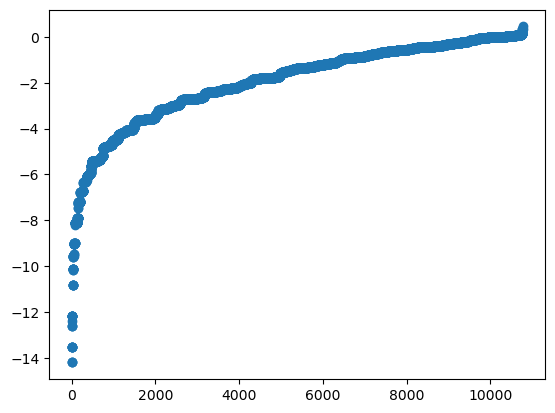

In [10]:
plt.scatter(x=final_df.index, y=final_df['Expected_Utils'])

In [11]:
# Above -1 util threshold

total_obs = len(final_df.loc[final_df['Expected_Utils'] > -1])
rbi_outcomes = final_df.loc[final_df['Expected_Utils'] > -1]['Rbi_steal_unique'].sum()
rbi_outcomes_stay = final_df.loc[final_df['Expected_Utils'] > -1]['Rbi_stay'].sum()
past_success_steal_prob = final_df.loc[final_df['Expected_Utils'] > -1]['Past_Steal_Success'].mean()

print(f'''Total Obs - {total_obs} with rbi outcomes - {rbi_outcomes} and prob of success of steal- {past_success_steal_prob} means that there is an  expected rbi return of {rbi_outcomes * past_success_steal_prob } this means you can expect a gain of {rbi_outcomes * past_success_steal_prob - rbi_outcomes_stay} RBis by choosing steal

With percentage of rbis gained per attempted steal - {rbi_outcomes * past_success_steal_prob / total_obs}''')


Total Obs - 4345 with rbi outcomes - 1854 and prob of success of steal- 0.8188032220943804 means that there is an  expected rbi return of 1518.0611737629813 this means you can expect a gain of 588.0611737629813 RBis by choosing steal

With percentage of rbis gained per attempted steal - 0.3493811677245066


In [12]:
# Less than -1 threshold

total_obs = len(final_df.loc[final_df['Expected_Utils'] < -1])

rbi_outcomes = final_df.loc[final_df['Expected_Utils'] < -1]['Rbi_steal_unique'].sum()
rbi_outcomes_stay = final_df.loc[final_df['Expected_Utils'] < -1]['Rbi_stay'].sum()
past_success_steal_prob = final_df.loc[final_df['Expected_Utils'] < -1]['Past_Steal_Success'].mean()

print(f'''Total Obs - {total_obs} with rbi outcomes - {rbi_outcomes} and prob of success of steal- {past_success_steal_prob} means that there is an  expected rbi return of {rbi_outcomes * past_success_steal_prob } this means you can expect a gain of {rbi_outcomes * past_success_steal_prob - rbi_outcomes_stay} RBis by choosing steal or by choosing to stay gain {rbi_outcomes_stay} rbis

With percentage of rbis gained per attempted steal - {rbi_outcomes * past_success_steal_prob / total_obs}''')


Total Obs - 6422 with rbi outcomes - 2607 and prob of success of steal- 0.6731236374960977 means that there is an  expected rbi return of 1754.8333229523269 this means you can expect a gain of 395.83332295232685 RBis by choosing steal or by choosing to stay gain 1359 rbis

With percentage of rbis gained per attempted steal - 0.27325339815514277


In [14]:
dict_hist = {}

for i in np.arange(-3, 1, 0.1):
    
    # Less than -1 threshold

    total_obs = len(final_df.loc[final_df['Expected_Utils'] > i])

    rbi_outcomes = final_df.loc[final_df['Expected_Utils'] > i]['Rbi_steal_unique'].sum()
    rbi_outcomes_stay = final_df.loc[final_df['Expected_Utils'] > i]['Rbi_stay'].sum()
    past_success_steal_prob = final_df.loc[final_df['Expected_Utils'] < -1]['Past_Steal_Success'].mean()
    
    dict_hist[i] = {}
    
    dict_hist[i]['Expected_RBI_Return'] = rbi_outcomes * past_success_steal_prob
    
    dict_hist[i]['Exp_Gain'] = rbi_outcomes * past_success_steal_prob - rbi_outcomes_stay
    
    dict_hist[i]['Stay_RBI'] = rbi_outcomes_stay
    
    dict_hist[i]['percent_return'] = rbi_outcomes * past_success_steal_prob / total_obs



/var/folders/g3/164q6cz52jv0sjllnsg7jdsm0000gn/T/ipykernel_5071/1315782831.py:21: RuntimeWarning: invalid value encountered in double_scalars
  dict_hist[i]['percent_return'] = rbi_outcomes * past_success_steal_prob / total_obs


In [15]:
pd.DataFrame(dict_hist).transpose()

,Expected_RBI_Return,Exp_Gain,Stay_RBI,percent_return
-3.000000e+00,2391.608284,670.608284,1721.0,0.287522
-2.900000e+00,2349.874618,649.874618,1700.0,0.287341
-2.800000e+00,2343.816506,645.816506,1698.0,0.286986
-2.700000e+00,2262.368546,640.368546,1622.0,0.288457
-2.600000e+00,2189.671193,606.671193,1583.0,0.287736
-2.500000e+00,2188.324945,614.324945,1574.0,0.288051
-2.400000e+00,2123.031953,580.031953,1543.0,0.286548
-2.300000e+00,2034.852756,506.852756,1528.0,0.284316
-2.200000e+00,1926.479851,460.479851,1466.0,0.282973
-2.100000e+00,1884.746185,432.746185,1452.0,0.282232
